In [1]:
from __future__ import division, print_function
from IPython.display import display

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import sys
sys.path.append('..')

In [3]:
from pummeler.data import election_data, centroids_cartesian

In [89]:
from sklearn import cross_validation as cv, linear_model, metrics
import scipy.stats
import GPy

**NOTE**: the current version of GPy doesn't support Laplace inference with binomial likelihoods! There's [a pull request](https://github.com/SheffieldML/GPy/pull/356). I've merged it into the otherwise-latest GPy, which works enough for what we're doing here, in [my `binomial_laplace_new` branch](https://github.com/dougalsutherland/GPy/tree/binomial_laplace_new):

    git clone https://github.com/dougalsutherland/GPy/ -b binomial_laplace_new
    cd GPy
    python setup.py install

### Load data

The embeddings:

In [5]:
SORT_DIR = '../SORT_DIR'
with np.load(os.path.join(SORT_DIR, 'embeddings.npz') as d:
    display(d.keys())
    locals().update(**d)

['emb_lin', 'freqs', 'bandwidth', 'emb_rff', 'region_names', 'feature_names']

The centroids, which we load in 3d Cartesian coordinates (in units of km) so that distances are accurate.

In [6]:
centroids = np.asarray(centroids_cartesian('00').loc[region_names])

The paper reported the learned lengthscale in some weird units, so let's start it at "a little more than half the median distance between locations".

In [7]:
from sklearn.metrics.pairwise import euclidean_distances

In [8]:
D2 = euclidean_distances(centroids, squared=True)
np.sqrt(np.median(D2[np.triu_indices_from(D2, k=1)]))

1090.2906089823362

In [9]:
election = election_data().loc[region_names]

In [10]:
election.head()

,votes_D,votes_G,votes_L,votes_R,votes_oth
region,,,,,
AK_00_01,122640,2917,7392,164676,2870
AL_00_01,18424,169,607,66016,275
AL_00_02,75150,116,301,62561,227
AL_00_03,15328,175,536,71439,402
AL_00_04,37374,211,631,74343,432


Ignore third-party votes; `n` is number of votes, `y` is number Democratic.

In [11]:
n = np.asarray(election.votes_D + election.votes_R)
y = np.asarray(election.votes_D)

In [12]:
X_lin = np.hstack([emb_lin, centroids])
X_rff = np.hstack([emb_rff, centroids])

In [13]:
n_regions = len(region_names)
n_feats = len(feature_names)
n_rff = emb_rff.shape[1]

## Try out the model

Just do a single train/test split for right now.

In [14]:
train, test = next(iter(cv.ShuffleSplit(
            n_regions, test_size=.1, random_state=10)))

### Linear embeddings

Here's the model using linear embeddings (i.e. feature means), along with the Matérn kernel on centroids, with hyperparameters more or less what the paper said worked well:

In [15]:
m_lin = GPy.core.GP(
    X_lin[train], y[train, np.newaxis],
    kernel=
        GPy.kern.Linear(
            n_feats, variances=4.56,
            active_dims=range(0, n_feats))
        + GPy.kern.Matern32(
            3, variance=0.18, lengthscale=560,
            active_dims=range(n_feats, n_feats + 3)),
    likelihood=GPy.likelihoods.Binomial(),
    Y_metadata={'trials': n[train, np.newaxis]},
    inference_method=GPy.inference.latent_function_inference.Laplace(),
)

 /usr/local/anaconda/lib/python2.7/site-packages/GPy-1.0.9-py2.7-macosx-10.6-x86_64.egg/GPy/inference/latent_function_inference/laplace.py:225: UserWarning:Not perfect mode found (f_hat). difference: 207.929438715, iteration: 30 out of max 30


In [16]:
m_lin

gp.,value,constraints,priors
sum.linear.variances,4.56,+ve,
sum.Mat32.variance,0.18,+ve,
sum.Mat32.lengthscale,560.0,+ve,


In [17]:
def eval_preds(phat):
    plt.plot([0, 1], [0, 1], color='r')
    plt.scatter(y[test] / n[test], phat.squeeze())
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    return metrics.explained_variance_score(y[test] / n[test], phat)

0.89288486470236583

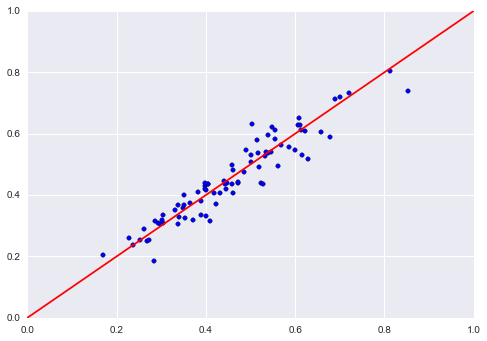

In [23]:
f, fstd = m_lin._raw_predict(X_lin[test])
phat = scipy.stats.norm.cdf(f.squeeze())
eval_preds(phat)

Predictions are pretty good. We can try optimizing it, see if that helps at all:

In [24]:
m_lin.optimize()

 /usr/local/anaconda/lib/python2.7/site-packages/GPy-1.0.9-py2.7-macosx-10.6-x86_64.egg/GPy/inference/latent_function_inference/laplace.py:229: UserWarning:f_hat now fine again. difference: 5.05701755174e-05, iteration: 4 out of max 30
 /usr/local/anaconda/lib/python2.7/site-packages/GPy-1.0.9-py2.7-macosx-10.6-x86_64.egg/GPy/inference/latent_function_inference/laplace.py:225: UserWarning:Not perfect mode found (f_hat). difference: 2.07836337076, iteration: 30 out of max 30
 /usr/local/anaconda/lib/python2.7/site-packages/GPy-1.0.9-py2.7-macosx-10.6-x86_64.egg/GPy/inference/latent_function_inference/laplace.py:229: UserWarning:f_hat now fine again. difference: 2.15533873416e-07, iteration: 14 out of max 30
 /usr/local/anaconda/lib/python2.7/site-packages/GPy-1.0.9-py2.7-macosx-10.6-x86_64.egg/GPy/inference/latent_function_inference/laplace.py:225: UserWarning:Not perfect mode found (f_hat). difference: 0.00392608354468, iteration: 30 out of max 30
 /usr/local/anaconda/lib/python2.7/sit

In [25]:
m_lin

gp.,value,constraints,priors
sum.linear.variances,3.62253710608,+ve,
sum.Mat32.variance,0.136401266784,+ve,
sum.Mat32.lengthscale,560.00075348,+ve,


0.88431398469567279

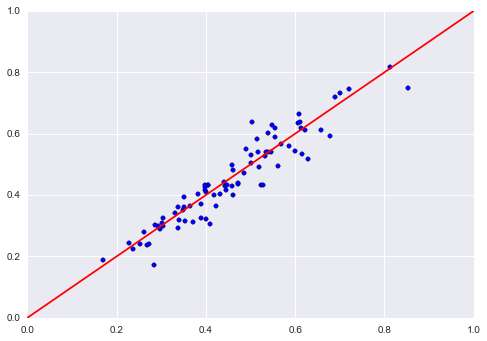

In [26]:
f, fstd = m_lin._raw_predict(X_lin[test])
phat = scipy.stats.norm.cdf(f.squeeze())
eval_preds(phat)

...the same.

### Ridge regression

Of course, linear-kernel GPs are just ridge regression. If we drop the spatial kernel, we can investigate the importance of different features:

0.84915614480653812

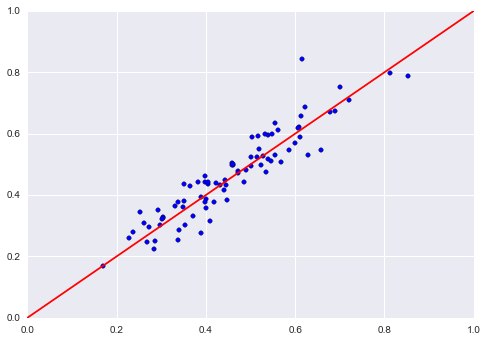

In [43]:
ridge = linear_model.RidgeCV()
ridge.fit(X_lin[train], y[train] / n[train])
ridge_phat = ridge.predict(X_lin[test])
eval_preds(ridge_phat)

In [71]:
w = np.abs(ridge.coef_).argsort()[:-20:-1]
for f, wt in zip(feature_names[w], ridge.coef_[w]):
    print('{:>15}  {: .4}'.format(f, wt))

         RELP_0   0.279
          MAR_1  -0.242
         HISP_1  -0.2247
          MAR_5   0.2217
        MSP_6.0   0.2217
        POBP_19   0.2188
 POWPUMA_6500.0   0.2176
        MSP_1.0  -0.2102
       ANC1P_32  -0.1976
      POWSP_2.0  -0.1975
       ANC1P_82   0.1959
       ANC1P_21  -0.1936
 MIGPUMA_2090.0  -0.1905
      POWSP_6.0   0.1896
      SCHL_14.0   0.1727
        POBP_24  -0.1667
     LANP_625.0   0.1655
        GCL_2.0   0.1647
        HISP_24   0.1645


- `RELP_0` shouldn't happen according to [the documentation](http://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2006-2010.pdf). Dunno what that means.
- `MAR_1` means "married."
- `HISP_1` means "not Hispanic."
- `MAR_5` means "never married."
- `MSP_6.0` also means "never married."
- `POBP_19` means "born in Iowa."
- `POWPUMA_6500.0` means you work in either a specific place in California or a specific place in Texas....
- `MSP_1.0` means "now married, spouse present."
- `ANC1P_32` means German ancestry, listed first.
- `POWSP_2.0` means "works in Alaska".
- `ANC1P_82` means Norwegian ancestry, listed first.
- `ANC1P_21` is Dutch.

### Avoiding referencing specific locations

Note that several of those refer to specific places (`POWPUMA` refers to working in a specific area; `POWSP_6.0` refers to a person who works in California; etc). We might try to avoid that:

0.81360980824944207

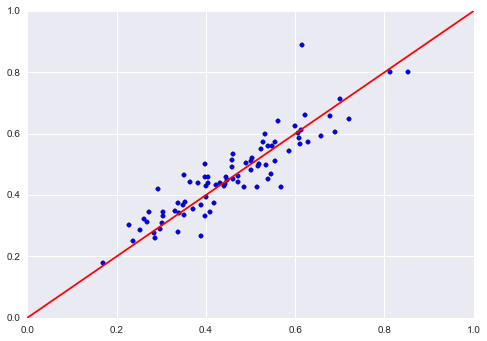

In [42]:
no_us_places = np.array([
    not (s.startswith('POBP_') or s.startswith('RELP_')
         or s.startswith('POWPUMA_') or s.startswith('POWSP')
         or s.startswith('MIGSP_') or s.startswith('MIGPUMA_'))
    for s in feature_names
])
ridge2 = linear_model.RidgeCV()
ridge2.fit(X_lin[np.ix_(train, no_us_places)], y[train] / n[train])
ridge2_phat = ridge2.predict(X_lin[np.ix_(test, no_us_places)])
eval_preds(ridge2_phat)

Hurts a little, but not much.

In [68]:
w = np.abs(ridge2.coef_).argsort()[:-20:-1]
for f, wt in zip(feature_names[w], ridge2.coef_[w]):
    print('{:>15}  {: .4}'.format(f, wt))

        GCL_2.0   0.491
           WKHP  -0.4464
        GCL_nan  -0.3558
       SCHG_4.0  -0.3353
     LANP_966.0   0.3153
          MAR_5   0.3153
        ANC1P_5  -0.2868
          MAR_1  -0.2656
       SCHG_7.0   0.2326
      ANC1P_904   0.2236
     LANP_864.0  -0.2198
       ANC1P_12   0.216
        RELP_13  -0.2109
       SCHG_5.0   0.2087
      ANC2P_822  -0.2054
      ANC1P_899  -0.1942
 naicsp02_32621  -0.1866
    indp02_9780  -0.1866
     indp07_nan   0.1842


- `GCL_2.0` indicates that the person is not a grandparent living with their grandchildren.
- `WKHP` is the number of hours worked per week over the last year.
- `GCL_nan` that either the person being referenced is under 30 or the household is an institution of some kind.
- `SCHG_4.0` indicates that the person is currently in middle school. (Remember that people under 18 are not in this dataset, so this is a rare feature.)
- `LANP_966.0` means that an American Indian language (other than Apache, "Navaho", Dakota, Keres, Cherokee, or Zuni) is spoken at home.
- `MAR_5` means "never married".
- `ANC1P_5` refers to Basque ancestry.
- `MAR_1` means "married".
- `SCHG_7.0` is people currently in graduate or professional school.
- `ANC1P_904` is "Negro" ancestry. (Note that "Afro American", "Afro", "African American", "Black" are also options.)
- `LANP_864.0` means "Navaho" is spoken at home.
- `ANC1P_12` is "British Isles" ancestry ("British" is also an option).

### Random Fourier feature embeddings

In [84]:
m_rff = GPy.core.GP(
    X_rff[train], y[train, np.newaxis],
    kernel=
        GPy.kern.Linear(
            n_rff, variances=4.56,
            active_dims=range(0, n_rff))
        + GPy.kern.Matern32(
            3, variance=0.18, lengthscale=560,
            active_dims=range(n_rff, n_rff + 3)),
    likelihood=GPy.likelihoods.Binomial(),
    Y_metadata={'trials': n[train, np.newaxis]},
    inference_method=GPy.inference.latent_function_inference.Laplace(),
)

 /usr/local/anaconda/lib/python2.7/site-packages/GPy-1.0.9-py2.7-macosx-10.6-x86_64.egg/GPy/inference/latent_function_inference/laplace.py:225: UserWarning:Not perfect mode found (f_hat). difference: 0.000293246681395, iteration: 30 out of max 30


In [85]:
m_rff.optimize()

In [91]:
m_rff

gp.,value,constraints,priors
sum.linear.variances,4.56,+ve,
sum.Mat32.variance,0.18,+ve,
sum.Mat32.lengthscale,560.0,+ve,


0.85751220633828462

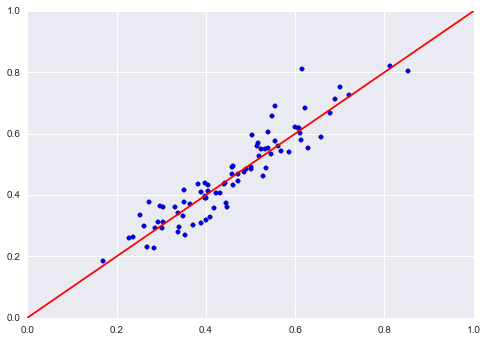

In [94]:
f, fstd = m_rff._raw_predict(X_rff[test])
phat = scipy.stats.norm.cdf(f.squeeze())
eval_preds(phat)

About the same as, maybe slightly worse than, the straight linear embeddings...